In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import yaml
import scipy.interpolate as interpolate
from scipy.stats import norm, chi2
from pathlib import Path
import uproot

plt.rcParams['figure.figsize'] = [15,5]#[15, 5]
plt.rcParams['font.size'] = 15

# Multiple files with data:

In [20]:
def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas


saveplotname = "EBL10000_PWL_LP_franceschini_paper" #Name of the plot to ve saved
pathstring = "/data/magic/users-ifae/rgrau/EBL-splines/" #path where all the output files of EBL_MC ae stored
locname = pathstring + "EBL10000_PWL_LP_CTAN_alpha_with_0.0_Systematics_BOAT_2nd_phase" #Folder of the data you want to plot
loc = Path(locname)

files = sorted([f for f in loc.glob("EBL*.hdf5")]) 
chisqs_iter = []
alphas_iter = []
bad = 0
nans = 0
infs = 0
nonconv = 0
toochi = 0

for name in files:
    try:
        with h5py.File(name, "r") as fileop:
            if 'chisqs' in fileop:  #this is to avoid problems with files that did not converge properly and would make the plot to crash
                chisqs, alphas = extract(fileop)
                if (chisqs == np.inf).any():
                    infs = infs + 1
                elif (chisqs == 99999999).any():
                    nonconv = nonconv + 1
                    print(name)
                elif (np.isnan(chisqs).any()):
                    nans = nans + 1
                else:
                    chisqs_iter.append(chisqs)
                    alphas_iter.append(alphas)          
    except:
        print("{0} not finished yet.".format(name)) #to avoid crashes when the code is still running for some iteration
        bad = bad + 1
print("There were {0} nans, {1} infinites and {2} non convergences".format(nans, infs, nonconv))

with open(pathstring + "EBL_fit_config2_1.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

if fit_func_name == "MBPWL":
        knots = inp_config["knots"]
        Efirst = inp_config["Efirst"]
        Elast = inp_config["Elast"]

There were 0 nans, 3 infinites and 0 non convergences


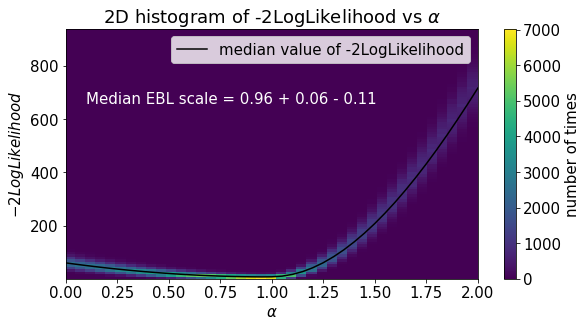

A 70.72 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 94.74 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 99.63 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
Δχ^2 min-0 = 52.98
Δχ^2 min-2 = 709.17


In [21]:
#to compare with the real MAGIC data (comment if not needed)
file2 = uproot.open("Output_fitebl.root:Chi2_1ES1011_Feb2014_LP")
magicalphas = file2.values()[0]
magichis = file2.values()[1]

average = "median" #choose if you want to plot the median or the mean of the -2LogLikelihood values

plt.rcParams['figure.figsize'] = [8.5,4.8]#[15, 5]

niter = len(chisqs_iter)

alphas_iter2 = np.concatenate(alphas_iter) 
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]


fig, ax = plt.subplots()
if average == "median":
    ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.median(chisqs_iter,0), order, axis=0), color = "black", label="median value of -2LogLikelihood")
elif average == "mean":
    ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of -2LogLikelihood")
ybins = np.linspace(min(chisqs_iter2), 100, 100)
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),100], label="histogram of -2LogLikelihood values", rasterized=True)#, norm = colors.LogNorm()


ax.plot(magicalphas, magichis, color = "red", label= "Chi2 fit with the real data")#if you want to compare with the real MAGIC data (comment if you don't want)


ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.legend()
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of -2LogLikelihood vs $\alpha$")

interpx2 = np.arange(first_bin, last_bin, step/500)
alphas_reord_temp = np.take_along_axis(alphas_iter[0], order, axis=0)
sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
number = np.where(np.round(interpx2, decimals = 4) == 1)
for i in range(len(alphas_iter)):
    chisqs_reord_temp = np.take_along_axis(chisqs_iter[i], order, axis=0)
    f2 = interpolate.interp1d(alphas_reord_temp, chisqs_reord_temp, kind='cubic')
    chis_new_temp = np.array(f2(interpx2))
    sigma_1_0 = np.where(chis_new_temp <= 1 + np.min(chis_new_temp))
    sigma_2_0 = np.where(chis_new_temp <= 4 + np.min(chis_new_temp))
    sigma_3_0 = np.where(chis_new_temp <= 9 + np.min(chis_new_temp))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if number in sigma_2_0[0]:
        s2 += 1
    if number in sigma_3_0[0]:
        s3 += 1


order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/1000)
if average == "median":
    alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
    chisqs_reord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
    textminpos = "Median"
elif average == "mean":
    alphas_reord = np.take_along_axis(np.mean(alphas_iter, 0), order, axis=0)
    chisqs_reord = np.take_along_axis(np.mean(chisqs_iter, 0), order, axis=0)
    textminpos = "Mean"
f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='cubic')
chis_new = f1(interpx)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_1s = step/1000 * np.max(sigma_inter_1s) + first_bin
lower_bound_1s = step/1000 * np.min(sigma_inter_1s) + first_bin

minpos = "{0} EBL scale = {1:.2f} + {2:.2f} - {3:.2f}".format(textminpos, np.round(interpx[np.argmin(chis_new)], decimals = 3), np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 3),  np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 3))
ax.text(x = 0.05, y = 0.75, s=minpos, ha='left', va='top', transform=ax.transAxes, color = "white")
plt.tight_layout()
plt.savefig('chi2fits/{0}.pdf'.format(saveplotname))
plt.show()
print("A {sig:.2f} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / (niter) * 100, decimals = 3)))
print("A {sig:.2f} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / (niter) * 100, decimals = 3)))
print("A {sig:.2f} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / (niter) * 100, decimals = 3)))

print("\u0394" + "\u03C7" + r"^2" + " min-0 = {0:.2f}".format(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0)[0] - np.min(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))))
print("\u0394" + "\u03C7" + r"^2" + " min-2 = {0:.2f}".format(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0)[-1] - np.min(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))))


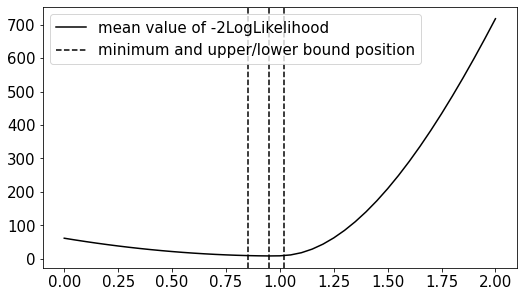

In [23]:
plt.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of -2LogLikelihood")
# plt.plot(mrkalphas, mrkchis, color = "red", label= "Chi2 fit with the real data")
# plt.plot(interpx, chis_new, color = "green", label = "interpol")

limits = plt.ylim()
limmin = limits[0]
limmax = limits[1]
sim_min = np.round(np.take_along_axis(alphas_iter[0], order, axis=0)[np.argmin(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))], decimals = 3)

plt.axvline(sim_min, color = "black", linestyle = "--", label = "minimum and upper/lower bound position")
plt.axvline(upper_bound_1s, color = "black", linestyle = "--")
plt.axvline(lower_bound_1s, color = "black", linestyle = "--")
# plt.axvline(1.002, color = "red", linestyle = "--", label = "minimum and upper/lower blund position")
# plt.axvline(1.002 + 0.149, color = "red", linestyle = "--")
# plt.axvline(1.002 - 0.149, color = "red", linestyle = "--")

# plt.axhline(np.min(np.mean(chisqs_iter,0)) +1)
plt.legend()
plt.show()


## Compute CDF and compare it to a $\chi^2$

0.8445812924186759


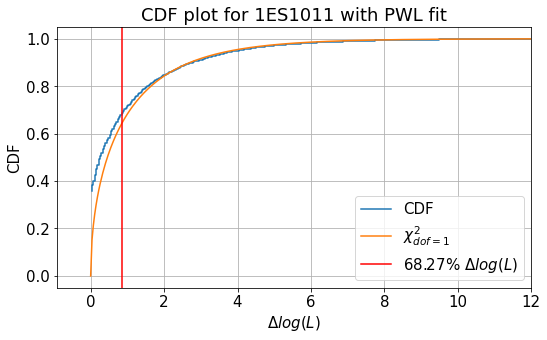

In [24]:
deltachi2 = np.zeros(niter)
for i in range(niter):
    deltachi2[i] = np.abs(np.min(chisqs_iter[i]) - chisqs_iter[i][np.where(np.round(alphas_iter[0], decimals = 4) == 1.)])
npoints = 19 #should be 19
nfreeparams = 2+2 #PWL 2, LP 3, MBPWL 2 + n breaks (not completely true for MBPWL + 1 for alpha as free parameter
ndof = npoints - nfreeparams
count, bins_count = np.histogram(deltachi2, bins=500)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
cov1 = np.where(cdf < 0.6827)[0]

chi2cdf = chi2.cdf(bins_count, df=1)
plt.step(bins_count[1:], cdf, label="CDF")
plt.plot(bins_count, chi2cdf, label = r"$\chi^2_{dof = 1}$")
# plt.axhline(y = 0.6827, label = "0.6827", color = "black")
# plt.axhline(y = 0.9545, label = "0.9545", color = "black")
# plt.axhline(y = 0.9973, label = "0.9973", color = "black")
plt.axvline(x = bins_count[1:][cov1[-1]], color = "red", label= "68.27% $\Delta log(L)$")
print(bins_count[1:][cov1[-1]])
plt.ylabel("CDF")
plt.xlabel(r"$\Delta log(L)$")
plt.xlim([None, 12])
plt.grid()
plt.title("CDF plot for 1ES1011 with PWL fit")
plt.legend()
plt.savefig('chi2fits/CDF_concave_LP_finke2022.pdf')
plt.show()

## In case we want to visualize one of the iterations:

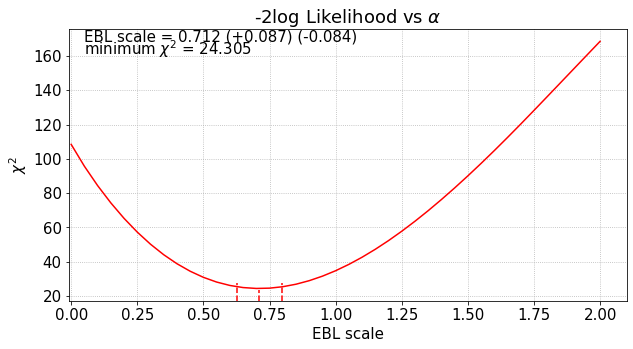

In [25]:
number_wanted = 101

for name in files:
    if "nit{0}of".format(number_wanted) in name.name:
        try:
            fileop = h5py.File(name, "r")
            if 'chisqs' in fileop:
                chisqs_desired, alphas_desired = extract(fileop)         
        except:
            print("{0} not finished yet.".format(name))
alpha_min = 0. #lowest EBL scale factor
alpha_max = 2. #hightes EBL scale factor
alpha_step = 0.05 #EBL scale bin size

order = np.argsort(alphas_desired)
alphas2 = np.take_along_axis(alphas_desired, order, axis=-1)
chisqs2 = np.take_along_axis(np.array(chisqs_desired), order, axis=-1)
interpx = np.arange(alpha_min, alpha_max, alpha_step/1000)
f1 = interpolate.interp1d(alphas2, chisqs2, kind='cubic')
chis_new = f1(interpx)
minimum = np.round(interpx[np.where(chis_new == np.min(chis_new))][0], decimals = 3)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound = np.round(interpx[np.max(sigma_inter_1s)], decimals = 3)
lower_bound = np.round(interpx[np.min(sigma_inter_1s)], decimals = 3)

plt.plot(alphas2, chisqs2, color = "red")
plt.axvline(minimum, ymax = 0.04, color = "red", linestyle = "--")
plt.axvline(upper_bound, ymax = 0.065, color = "red", linestyle = "--")
plt.axvline(lower_bound, ymax = 0.065, color = "red", linestyle = "--")
plt.xlabel("EBL scale")
plt.ylabel(r"$\chi^2$")
plt.grid(linestyle = ":")
plt.xlim(-0.01,None)
plt.title(r"-2log Likelihood vs $\alpha$")
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/1000, s="EBL scale = {0} (+{1}) (-{2})".format(minimum, np.round(upper_bound-minimum, decimals = 3), np.round(minimum-lower_bound, decimals = 3)))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/18, s = r"minimum $\chi^2$ = {0}".format(np.round(np.min(chis_new), decimals = 3)))
plt.show()